In [1]:
import numpy as np
import itertools

import jax
import jax.numpy as jnp

# -------------- helper libraries -------------- #
import sys
import os
import time
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import importlib

path_ = os.path.abspath(os.path.join('..', '00_utils'))

if path_ not in sys.path:
    sys.path.append(path_)
    
path_ = os.path.abspath(os.path.join('..', '00_models'))

if path_ not in sys.path:
    sys.path.append(path_)
    
path_ = os.path.abspath(os.path.join('..', '00_utils_training'))

if path_ not in sys.path:
    sys.path.append(path_)

from data_generation import generate_ode_data
from non_parametric_collocation import collocate_data
import collocation_obj

import run_train_toy

import logging
logging.basicConfig(level=logging.ERROR, filename='error_log.txt')

In [3]:
importlib.reload(collocation_obj)
Collocation = collocation_obj.Collocation

### Set Out Hyperparameter Optimization (Shared Parameters)
* network size
* regularization
* number of training points

### Pyomo-specific Hyperparameters
* number of collocation points with fixed n. of training points
* objective tolerances

### Sequential ODE Solver Hyperparameters
* learning rate
* number of training epochs
* ODE-solver tolerances


---
# Generate Data

In [80]:
importlib.reload(run_train_toy)
TrainerToy = run_train_toy.TrainerToy

def load_trainer(type_, spacing_type="chebyshev", detailed = False):
    data_params_ho = {
        'N': 200,
        'noise_level': 0.2,
        'ode_type': "harmonic_oscillator",
        'data_param': {"omega_squared": 2},
        'start_time': 0,
        'end_time': 10,
        'spacing_type': spacing_type,
        'initial_state': np.array([0.0, 1.0]),
        'detailed': detailed
    }

    data_params_vdp = {
        'N': 200,
        'noise_level': 0.1,
        'ode_type': "van_der_pol",
        'data_param': {"mu": 1, "omega": 1},
        'start_time': 0,
        'end_time': 15,
        'spacing_type': spacing_type,
        'initial_state': np.array([0.0, 1.0]),
        'detailed' : detailed
    }

    data_params_do = {
        'N': 200,
        'noise_level': 0.1,
        'ode_type': "damped_oscillation",
        'data_param': {"damping_factor": 0.1, "omega_squared": 1},
        'start_time': 0,
        'end_time': 10,
        'spacing_type': spacing_type,
        'initial_state': np.array([0.0, 1.0]),
        'detailed' : detailed
    }

    if type_ == "ho":
        p_ = data_params_ho
    elif type_ == "vdp":
        p_ = data_params_vdp
    elif type_ == "do":
        p_ = data_params_do
    else:
        raise ValueError(f"Invalid type {type_}")

    trainer = TrainerToy(p_, model_type="pyomo")
    trainer.prepare_inputs()
    return trainer

## Visualize Synthetic Data

In [81]:
trainer_ch = load_trainer("do")
print('-----')
trainer_gl = load_trainer("do", 'gauss_legendre')

/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_utils/non_parametric_collocation.py:95: UserWarning: Data transposed to match expected dimensions.
  warnings.warn("Data transposed to match expected dimensions.")


-----


/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_utils/non_parametric_collocation.py:95: UserWarning: Data transposed to match expected dimensions.
  warnings.warn("Data transposed to match expected dimensions.")


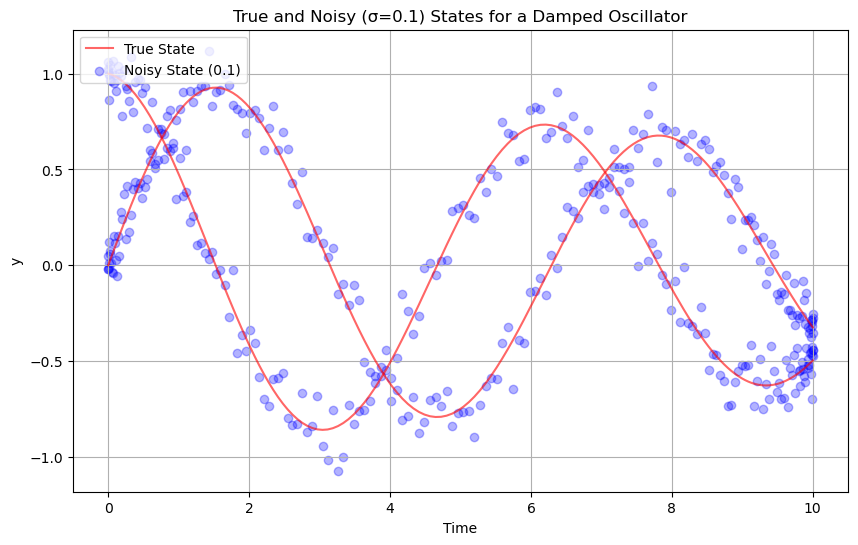

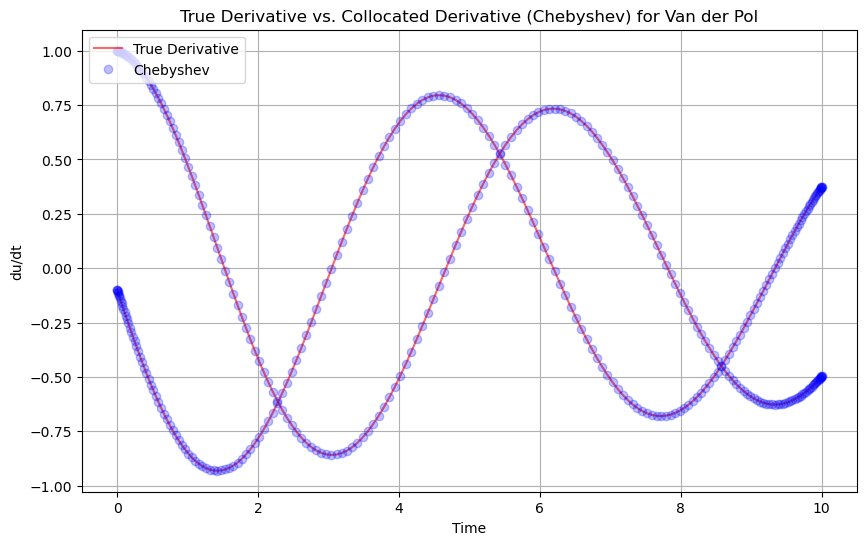

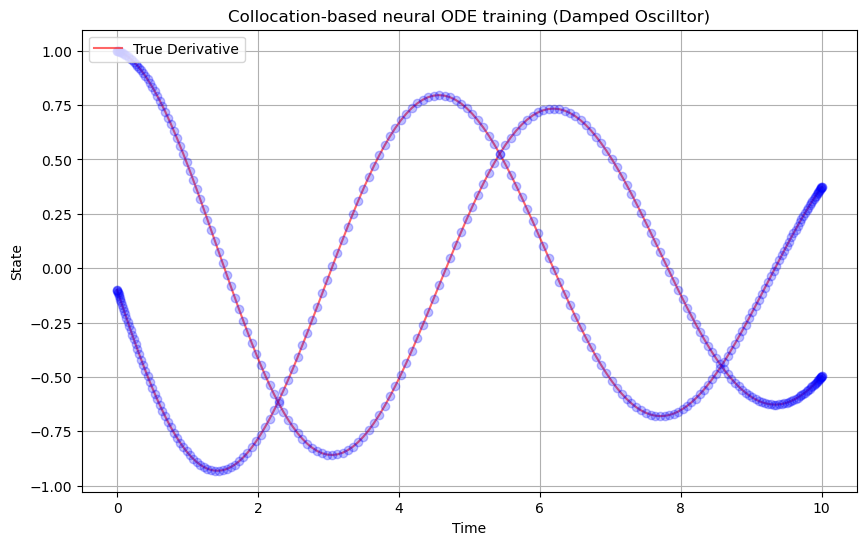

In [82]:
k = 200
D = trainer_ch.D

plt.figure(figsize=(10, 6))

plt.plot(trainer_ch.t, trainer_ch.y[:,0], color = 'red', alpha = 0.6, label = 'True State')
plt.plot(trainer_ch.t, trainer_ch.y[:,1], color = 'red', alpha = 0.6)
plt.scatter(trainer_ch.t, trainer_ch.y_noisy[:,0], color = 'blue', alpha = 0.3, label = 'Noisy State (0.1)')
plt.scatter(trainer_ch.t, trainer_ch.y_noisy[:,1], color = 'blue', alpha = 0.3)

plt.title("True and Noisy (σ=0.1) States for a Damped Oscillator")
plt.xlabel("Time")
plt.ylabel("y")
plt.legend(loc ="upper left")
plt.grid(True)
plt.show()

dy_dt_0 = []
dy_dt_1 = []

for i in range(len(trainer_ch.t)):
    dy_dt = (D[i] @ trainer_ch.y)
    dy_dt_0.append(dy_dt[0])
    dy_dt_1.append(dy_dt[1])

plt.figure(figsize=(10, 6))

plt.plot(trainer_ch.t, trainer_ch.true_derivative[:,0], color = 'red', alpha = 0.6, label = 'True Derivative')
plt.plot(trainer_ch.t, trainer_ch.true_derivative[:,1], color = 'red', alpha = 0.6)
plt.plot(trainer_ch.t[:k], dy_dt_0[:k], 'o', color = 'blue', alpha = 0.25, label = 'Chebyshev')
plt.plot(trainer_ch.t[:k], dy_dt_1[:k], 'o', color = 'blue', alpha = 0.25)

plt.title(f"True Derivative vs. Collocated Derivative (Chebyshev) for Van der Pol")
plt.xlabel("Time")
plt.ylabel("du/dt")
plt.legend(loc ="upper left")
plt.grid(True)
plt.show()

D = trainer_gl.D

dy_dt_0 = []
dy_dt_1 = []

for i in range(len(trainer_gl.t)):
    dy_dt = (D[i] @ trainer_gl.y)
    dy_dt_0.append(dy_dt[0])
    dy_dt_1.append(dy_dt[1])
    
k = 200
plt.figure(figsize=(10, 6))

plt.plot(trainer_gl.t, trainer_gl.true_derivative[:,0], color = 'red', alpha = 0.6, label = 'True Derivative')
plt.plot(trainer_gl.t, trainer_gl.true_derivative[:,1], color = 'red', alpha = 0.6)
plt.plot(trainer_gl.t[:k], dy_dt_0[:k], 'o',color = 'blue', alpha = 0.25)
plt.plot(trainer_gl.t[:k], dy_dt_1[:k], 'o',color = 'blue', alpha = 0.25)

plt.title(f"Collocation-based neural ODE training (Damped Oscilltor)")
plt.xlabel("Time")
plt.ylabel("State")
plt.legend(loc ="upper left")
plt.grid(True)
plt.show()

## Network Size

#### Regularization [X]
#### Pre-initalization [X]
#### Tolerances [X]
#### Network Sizes []

In [83]:
def extract_metrics(results_dict):
    time_elapsed, mse_train, mse_test = [], [], []
    for key, value in results_dict.items():
        time_elapsed.append(value['time_elapsed'])
        mse_train.append(value['mse_train'].item())
        mse_test.append(value['mse_test'].item())
    return time_elapsed, mse_train, mse_test

In [84]:
tol_list = [1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8]
param_combinations = list(itertools.product(tol_list, tol_list))

In [205]:
def run(optimization_type):
  tol = 1e-8
  params_model = {
      'layer_widths': [2, 16, 2],
      'act_func': 'tanh',
      'penalty_lambda_reg': 0.01,
      'time_invariant': True,
      'w_init_method': 'xavier',
      "reg_norm": False,
      "skip_collocation": np.inf,
      'params': 
              {
            "tol":tol, 
            #"dual_inf_tol": tol, 
            #"compl_inf_tol": tol,
            #"constr_viol_tol": tol, 
            #"bound_relax_factor": 0.01,
            #"acceptable_tol": 1e-15,
            #"acceptable_constr_viol_tol": 1e-15,
            #"acceptable_dual_inf_tol": 1e-15,
            #"acceptable_compl_inf_tol": 1e-15,
            "acceptable_iter": 0,    
            "halt_on_ampl_error" : 'yes',
            "print_level": 5, 
            "max_iter": 3000}}

  TRAINER = load_trainer("ho")
  RESULTS = {}
  REPEATS = 1

  if optimization_type == 'regularization':
    param_combinations = [0, 1e-6, 0.0001, 0.01, 0.1, 1]
    
  elif optimization_type == 'tolerances':
    tol_list = [1, 1e-1, 1e-2, 1e-4, 1e-6, 1e-8]
    param_combinations = list(itertools.product(tol_list, tol_list))
    
  elif optimization_type == 'reg_tol': 
    reg_list = [0.001, 0.01, 0.1]
    tol_list = [1e-6, 1e-7, 1e-8]
    param_combinations = list(itertools.product(reg_list, tol_list))
    
  elif optimization_type == 'skip_collocation':
    param_combinations = [np.inf, 25, 10, 5, 2, 1]
    
  elif optimization_type == 'training_convergence':
    data = ['ho', 'vdp', 'do']
    pre_initialize = [True, False]
    l = np.array([i for i in range(1, 100)]) # must be the last
    param_combinations = list(itertools.product(data, pre_initialize, l))
    tested_params = []
    
  elif optimization_type == 'network_size_grid_search':
    lw_list = [[2, 16, 2], [2, 32, 2], [2, 64, 2], [2, 128, 2]]
    reg_list = [0.0001, 0.001, 0.01]
    tol_list = [1e-4, 1e-6]
    param_combinations = list(itertools.product(lw_list, reg_list, tol_list))
    
  elif optimization_type == 'activation_function':
    act_func_list = ['tanh', 'softplus', 'sigmoid']
    data = ['ho', 'vdp', 'do']
    param_combinations = list(itertools.product(act_func_list, data))
    
  elif optimization_type == 'weights_init':
    weights_init_list = ['xavier', 'he', 'random']
    data = ['ho', 'vdp', 'do']
    param_combinations = list(itertools.product(weights_init_list, data))
  
  elif optimization_type == 'none':
    param_combinations = [0]  
  
  else:
    raise ValueError(f"Invalid optimization type {optimization_type}")
      
  total_iter = len(param_combinations)
  i = 1

  for param_comb in param_combinations:
      # PARAMETER UPDATE
      if optimization_type == 'regularization':
          params_model['penalty_lambda_reg'] = param_comb
      elif optimization_type == 'tolerances': 
          params_model['params']['tol'] = param_comb[0]
          params_model['params']['constr_viol_tol'] = param_comb[1]
          params_model['params']['compl_inf_tol'] = param_comb[1]
          params_model['params']['dual_inf_tol'] = param_comb[1]
              
      elif optimization_type == 'skip_collocation':
          params_model['skip_collocation'] = param_comb
          
      elif optimization_type == 'training_convergence':
          params_model['params']['max_iter'] = param_comb[2]
          
          if param_comb[2] == 1:
            TRAINER = load_trainer(param_comb[0])
            params_model['pre_initialize'] = param_comb[1]
            tested_params = []
          
          if (param_comb[0],param_comb[1]) in tested_params:
            continue
            
      elif optimization_type == 'network_size_grid_search':
          params_model['layer_widths'] = param_comb[0]
          params_model['penalty_lambda_reg'] = param_comb[1]
          params_model['params']['tol'] = param_comb[2]
          
      elif optimization_type == 'activation_function':
          params_model['act_func'] = param_comb[0]
          TRAINER = load_trainer(param_comb[1], detailed = True)
          
      elif optimization_type == 'weights_init':
          params_model['w_init_method'] = param_comb[0]
          TRAINER = load_trainer(param_comb[1])
      
      #for repeat in range(REPEATS):    
      try:
        TRAINER.train_pyomo(params_model)
        if optimization_type == 'training_convergence' and 'optimal' in TRAINER.termination:
          print(f"Optimal solution found at/before iteration {param_comb}")
          tested_params.append((param_comb[0], param_comb[1]))
      except Exception as e:
        RESULTS[param_comb] = {'time_elapsed': np.array(np.nan), 'mse_train': np.array(np.nan), 'mse_test': np.array(np.nan)}
        logging.error("Failed to complete training: {}".format(e))
        print(f"{e}")
        continue
      
      try:
        if optimization_type == 'network_size_grid_search':
          k = (param_comb[0][1], param_comb[1], param_comb[2])
          RESULTS[k] = TRAINER.extract_results_pyomo()
        else:
          RESULTS[param_comb] = TRAINER.extract_results_pyomo()
      except Exception as e:
        RESULTS[param_comb] = {'time_elapsed': np.array(np.nan), 'mse_train': np.array(np.nan), 'mse_test': np.array(np.nan)}
        logging.error("Failed to extract results: {}".format(e))
        print(f"{e}")
      
      print("Iteration:", i, "/", total_iter)
      i+=1
      
  return RESULTS

In [206]:
RESULTS = run('training_convergence')

/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_utils/non_parametric_collocation.py:95: UserWarning: Data transposed to match expected dimensions.
  warnings.warn("Data transposed to match expected dimensions.")
/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_utils/non_parametric_collocation.py:95: UserWarning: Data transposed to match expected dimensions.
  warnings.warn("Data transposed to match expected dimensions.")


current_16_08


/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:89: UserWarning: y_init should be structured such that each row represents a new time point.
  print(self.model.y)


Ipopt 3.14.16: tol=1e-08
acceptable_iter=0
halt_on_ampl_error=yes
print_level=5
max_iter=1


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:   105870
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    32665

Total number of variables............................:      482
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      482
                     variables with only upper bounds:        0


/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:89: UserWarning: y_init should be structured such that each row represents a new time point.
  print(self.model.y)


Ipopt 3.14.16: tol=1e-08
acceptable_iter=0
halt_on_ampl_error=yes
print_level=5
max_iter=2


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:   105870
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    32665

Total number of variables............................:      482
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      482
                     variables with only upper bounds:        0


/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:89: UserWarning: y_init should be structured such that each row represents a new time point.
  print(self.model.y)


Ipopt 3.14.16: tol=1e-08
acceptable_iter=0
halt_on_ampl_error=yes
print_level=5
max_iter=3


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:   105870
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    32665

Total number of variables............................:      482
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      482
                     variables with only upper bounds:        0


/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:89: UserWarning: y_init should be structured such that each row represents a new time point.
  print(self.model.y)


Ipopt 3.14.16: tol=1e-08
acceptable_iter=0
halt_on_ampl_error=yes
print_level=5
max_iter=4


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:   105870
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    32665

Total number of variables............................:      482
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      482
                     variables with only upper bounds:        0


/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:89: UserWarning: y_init should be structured such that each row represents a new time point.
  print(self.model.y)


Ipopt 3.14.16: tol=1e-08
acceptable_iter=0
halt_on_ampl_error=yes
print_level=5
max_iter=5


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:   105870
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    32665

Total number of variables............................:      482
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      482
                     variables with only upper bounds:        0


/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:89: UserWarning: y_init should be structured such that each row represents a new time point.
  print(self.model.y)


Ipopt 3.14.16: tol=1e-08
acceptable_iter=0
halt_on_ampl_error=yes
print_level=5
max_iter=6


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:   105870
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    32665

Total number of variables............................:      482
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      482
                     variables with only upper bounds:        0


/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:89: UserWarning: y_init should be structured such that each row represents a new time point.
  print(self.model.y)


Ipopt 3.14.16: tol=1e-08
acceptable_iter=0
halt_on_ampl_error=yes
print_level=5
max_iter=7


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:   105870
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    32665

Total number of variables............................:      482
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      482
                     variables with only upper bounds:        0


/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:89: UserWarning: y_init should be structured such that each row represents a new time point.
  print(self.model.y)


Ipopt 3.14.16: tol=1e-08
acceptable_iter=0
halt_on_ampl_error=yes
print_level=5
max_iter=8


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:   105870
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    32665

Total number of variables............................:      482
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      482
                     variables with only upper bounds:        0


/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:89: UserWarning: y_init should be structured such that each row represents a new time point.
  print(self.model.y)


Ipopt 3.14.16: tol=1e-08
acceptable_iter=0
halt_on_ampl_error=yes
print_level=5
max_iter=9


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:   105870
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    32665

Total number of variables............................:      482
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      482
                     variables with only upper bounds:        0


/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:89: UserWarning: y_init should be structured such that each row represents a new time point.
  print(self.model.y)


Ipopt 3.14.16: tol=1e-08
acceptable_iter=0
halt_on_ampl_error=yes
print_level=5
max_iter=10


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:   105870
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    32665

Total number of variables............................:      482
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      482
                     variables with only upper bounds:        0

/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:89: UserWarning: y_init should be structured such that each row represents a new time point.
  print(self.model.y)


Ipopt 3.14.16: tol=1e-08
acceptable_iter=0
halt_on_ampl_error=yes
print_level=5
max_iter=11


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:   105870
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    32665

Total number of variables............................:      482
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      482
                     variables with only upper bounds:        0

/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:89: UserWarning: y_init should be structured such that each row represents a new time point.
  print(self.model.y)


Ipopt 3.14.16: tol=1e-08
acceptable_iter=0
halt_on_ampl_error=yes
print_level=5
max_iter=12


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:   105870
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    32665

Total number of variables............................:      482
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      482
                     variables with only upper bounds:        0

/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:89: UserWarning: y_init should be structured such that each row represents a new time point.
  print(self.model.y)


Ipopt 3.14.16: tol=1e-08
acceptable_iter=0
halt_on_ampl_error=yes
print_level=5
max_iter=13


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:   105870
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    32665

Total number of variables............................:      482
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      482
                     variables with only upper bounds:        0

/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:89: UserWarning: y_init should be structured such that each row represents a new time point.
  print(self.model.y)


Ipopt 3.14.16: tol=1e-08
acceptable_iter=0
halt_on_ampl_error=yes
print_level=5
max_iter=14


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:   105870
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    32665

Total number of variables............................:      482
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      482
                     variables with only upper bounds:        0

/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:89: UserWarning: y_init should be structured such that each row represents a new time point.
  print(self.model.y)


Ipopt 3.14.16: tol=1e-08
acceptable_iter=0
halt_on_ampl_error=yes
print_level=5
max_iter=15


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:   105870
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    32665

Total number of variables............................:      482
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      482
                     variables with only upper bounds:        0

/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:89: UserWarning: y_init should be structured such that each row represents a new time point.
  print(self.model.y)


Ipopt 3.14.16: tol=1e-08
acceptable_iter=0
halt_on_ampl_error=yes
print_level=5
max_iter=16


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:   105870
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    32665

Total number of variables............................:      482
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      482
                     variables with only upper bounds:        0

/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:89: UserWarning: y_init should be structured such that each row represents a new time point.
  print(self.model.y)


Ipopt 3.14.16: tol=1e-08
acceptable_iter=0
halt_on_ampl_error=yes
print_level=5
max_iter=17


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:   105870
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    32665

Total number of variables............................:      482
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      482
                     variables with only upper bounds:        0

/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:89: UserWarning: y_init should be structured such that each row represents a new time point.
  print(self.model.y)


Ipopt 3.14.16: tol=1e-08
acceptable_iter=0
halt_on_ampl_error=yes
print_level=5
max_iter=18


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:   105870
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    32665

Total number of variables............................:      482
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      482
                     variables with only upper bounds:        0

/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:89: UserWarning: y_init should be structured such that each row represents a new time point.
  print(self.model.y)


Ipopt 3.14.16: tol=1e-08
acceptable_iter=0
halt_on_ampl_error=yes
print_level=5
max_iter=19


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:   105870
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    32665

Total number of variables............................:      482
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      482
                     variables with only upper bounds:        0

/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:89: UserWarning: y_init should be structured such that each row represents a new time point.
  print(self.model.y)


Ipopt 3.14.16: tol=1e-08
acceptable_iter=0
halt_on_ampl_error=yes
print_level=5
max_iter=20


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:   105870
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    32665

Total number of variables............................:      482
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      482
                     variables with only upper bounds:        0

/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:89: UserWarning: y_init should be structured such that each row represents a new time point.
  print(self.model.y)


Ipopt 3.14.16: tol=1e-08
acceptable_iter=0
halt_on_ampl_error=yes
print_level=5
max_iter=21


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:   105870
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    32665

Total number of variables............................:      482
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      482
                     variables with only upper bounds:        0

/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:89: UserWarning: y_init should be structured such that each row represents a new time point.
  print(self.model.y)


Ipopt 3.14.16: tol=1e-08
acceptable_iter=0
halt_on_ampl_error=yes
print_level=5
max_iter=22


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:   105870
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    32665

Total number of variables............................:      482
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      482
                     variables with only upper bounds:        0

/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:89: UserWarning: y_init should be structured such that each row represents a new time point.
  print(self.model.y)


Ipopt 3.14.16: tol=1e-08
acceptable_iter=0
halt_on_ampl_error=yes
print_level=5
max_iter=23


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:   105870
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    32665

Total number of variables............................:      482
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      482
                     variables with only upper bounds:        0

/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:89: UserWarning: y_init should be structured such that each row represents a new time point.
  print(self.model.y)


Ipopt 3.14.16: tol=1e-08
acceptable_iter=0
halt_on_ampl_error=yes
print_level=5
max_iter=24


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:   105870
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    32665

Total number of variables............................:      482
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      482
                     variables with only upper bounds:        0

/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:89: UserWarning: y_init should be structured such that each row represents a new time point.
  print(self.model.y)


Ipopt 3.14.16: tol=1e-08
acceptable_iter=0
halt_on_ampl_error=yes
print_level=5
max_iter=25


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:   105870
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    32665

Total number of variables............................:      482
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      482
                     variables with only upper bounds:        0

/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:89: UserWarning: y_init should be structured such that each row represents a new time point.
  print(self.model.y)


Ipopt 3.14.16: tol=1e-08
acceptable_iter=0
halt_on_ampl_error=yes
print_level=5
max_iter=26


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:   105870
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    32665

Total number of variables............................:      482
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      482
                     variables with only upper bounds:        0

/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:89: UserWarning: y_init should be structured such that each row represents a new time point.
  print(self.model.y)


Ipopt 3.14.16: tol=1e-08
acceptable_iter=0
halt_on_ampl_error=yes
print_level=5
max_iter=27


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:   105870
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    32665

Total number of variables............................:      482
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      482
                     variables with only upper bounds:        0

/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_utils/non_parametric_collocation.py:95: UserWarning: Data transposed to match expected dimensions.
  warnings.warn("Data transposed to match expected dimensions.")


current_16_08
Ipopt 3.14.16: tol=1e-08
acceptable_iter=0
halt_on_ampl_error=yes
print_level=5
max_iter=1


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:   105870
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    32665

Total number of variables............................:      482
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      482
                     variables with only upper bou

/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_utils/non_parametric_collocation.py:95: UserWarning: Data transposed to match expected dimensions.
  warnings.warn("Data transposed to match expected dimensions.")


current_16_08


/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:89: UserWarning: y_init should be structured such that each row represents a new time point.
  print(self.model.y)


Ipopt 3.14.16: tol=1e-08
acceptable_iter=0
halt_on_ampl_error=yes
print_level=5
max_iter=1


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:   105870
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    32665

Total number of variables............................:      482
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      482
                     variables with only upper bounds:        0


/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:89: UserWarning: y_init should be structured such that each row represents a new time point.
  print(self.model.y)


Ipopt 3.14.16: tol=1e-08
acceptable_iter=0
halt_on_ampl_error=yes
print_level=5
max_iter=2


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:   105870
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    32665

Total number of variables............................:      482
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      482
                     variables with only upper bounds:        0


/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:89: UserWarning: y_init should be structured such that each row represents a new time point.
  print(self.model.y)


Ipopt 3.14.16: tol=1e-08
acceptable_iter=0
halt_on_ampl_error=yes
print_level=5
max_iter=3


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:   105870
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    32665

Total number of variables............................:      482
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      482
                     variables with only upper bounds:        0


/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:89: UserWarning: y_init should be structured such that each row represents a new time point.
  print(self.model.y)


Ipopt 3.14.16: tol=1e-08
acceptable_iter=0
halt_on_ampl_error=yes
print_level=5
max_iter=4


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:   105870
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    32665

Total number of variables............................:      482
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      482
                     variables with only upper bounds:        0


/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:89: UserWarning: y_init should be structured such that each row represents a new time point.
  print(self.model.y)


Ipopt 3.14.16: tol=1e-08
acceptable_iter=0
halt_on_ampl_error=yes
print_level=5
max_iter=5


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:   105870
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    32665

Total number of variables............................:      482
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      482
                     variables with only upper bounds:        0


/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:89: UserWarning: y_init should be structured such that each row represents a new time point.
  print(self.model.y)


Ipopt 3.14.16: tol=1e-08
acceptable_iter=0
halt_on_ampl_error=yes
print_level=5
max_iter=6


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:   105870
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    32665

Total number of variables............................:      482
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      482
                     variables with only upper bounds:        0


/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:89: UserWarning: y_init should be structured such that each row represents a new time point.
  print(self.model.y)


Ipopt 3.14.16: tol=1e-08
acceptable_iter=0
halt_on_ampl_error=yes
print_level=5
max_iter=7


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:   105870
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    32665

Total number of variables............................:      482
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      482
                     variables with only upper bounds:        0


/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:89: UserWarning: y_init should be structured such that each row represents a new time point.
  print(self.model.y)


Ipopt 3.14.16: tol=1e-08
acceptable_iter=0
halt_on_ampl_error=yes
print_level=5
max_iter=8


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:   105870
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    32665

Total number of variables............................:      482
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      482
                     variables with only upper bounds:        0


/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:89: UserWarning: y_init should be structured such that each row represents a new time point.
  print(self.model.y)


Ipopt 3.14.16: tol=1e-08
acceptable_iter=0
halt_on_ampl_error=yes
print_level=5
max_iter=9


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:   105870
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    32665

Total number of variables............................:      482
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      482
                     variables with only upper bounds:        0


/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:89: UserWarning: y_init should be structured such that each row represents a new time point.
  print(self.model.y)


Ipopt 3.14.16: tol=1e-08
acceptable_iter=0
halt_on_ampl_error=yes
print_level=5
max_iter=10


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:   105870
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    32665

Total number of variables............................:      482
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      482
                     variables with only upper bounds:        0

/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:89: UserWarning: y_init should be structured such that each row represents a new time point.
  print(self.model.y)


Ipopt 3.14.16: tol=1e-08
acceptable_iter=0
halt_on_ampl_error=yes
print_level=5
max_iter=11


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:   105870
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    32665

Total number of variables............................:      482
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      482
                     variables with only upper bounds:        0

/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:89: UserWarning: y_init should be structured such that each row represents a new time point.
  print(self.model.y)


Ipopt 3.14.16: tol=1e-08
acceptable_iter=0
halt_on_ampl_error=yes
print_level=5
max_iter=12


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:   105870
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    32665

Total number of variables............................:      482
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      482
                     variables with only upper bounds:        0

/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:89: UserWarning: y_init should be structured such that each row represents a new time point.
  print(self.model.y)


Ipopt 3.14.16: tol=1e-08
acceptable_iter=0
halt_on_ampl_error=yes
print_level=5
max_iter=13


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:   105870
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    32665

Total number of variables............................:      482
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      482
                     variables with only upper bounds:        0

/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:89: UserWarning: y_init should be structured such that each row represents a new time point.
  print(self.model.y)


Ipopt 3.14.16: tol=1e-08
acceptable_iter=0
halt_on_ampl_error=yes
print_level=5
max_iter=14


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:   105870
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    32665

Total number of variables............................:      482
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      482
                     variables with only upper bounds:        0

/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:89: UserWarning: y_init should be structured such that each row represents a new time point.
  print(self.model.y)


Ipopt 3.14.16: tol=1e-08
acceptable_iter=0
halt_on_ampl_error=yes
print_level=5
max_iter=15


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:   105870
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    32665

Total number of variables............................:      482
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      482
                     variables with only upper bounds:        0

/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:89: UserWarning: y_init should be structured such that each row represents a new time point.
  print(self.model.y)


Ipopt 3.14.16: tol=1e-08
acceptable_iter=0
halt_on_ampl_error=yes
print_level=5
max_iter=16


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:   105870
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    32665

Total number of variables............................:      482
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      482
                     variables with only upper bounds:        0

/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:89: UserWarning: y_init should be structured such that each row represents a new time point.
  print(self.model.y)


Ipopt 3.14.16: tol=1e-08
acceptable_iter=0
halt_on_ampl_error=yes
print_level=5
max_iter=17


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:   105870
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    32665

Total number of variables............................:      482
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      482
                     variables with only upper bounds:        0

/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:89: UserWarning: y_init should be structured such that each row represents a new time point.
  print(self.model.y)


Ipopt 3.14.16: tol=1e-08
acceptable_iter=0
halt_on_ampl_error=yes
print_level=5
max_iter=18


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:   105870
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    32665

Total number of variables............................:      482
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      482
                     variables with only upper bounds:        0

/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:89: UserWarning: y_init should be structured such that each row represents a new time point.
  print(self.model.y)


Ipopt 3.14.16: tol=1e-08
acceptable_iter=0
halt_on_ampl_error=yes
print_level=5
max_iter=19


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:   105870
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    32665

Total number of variables............................:      482
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      482
                     variables with only upper bounds:        0

/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:89: UserWarning: y_init should be structured such that each row represents a new time point.
  print(self.model.y)


Ipopt 3.14.16: tol=1e-08
acceptable_iter=0
halt_on_ampl_error=yes
print_level=5
max_iter=20


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:   105870
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    32665

Total number of variables............................:      482
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      482
                     variables with only upper bounds:        0

/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:89: UserWarning: y_init should be structured such that each row represents a new time point.
  print(self.model.y)


Ipopt 3.14.16: tol=1e-08
acceptable_iter=0
halt_on_ampl_error=yes
print_level=5
max_iter=21


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:   105870
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    32665

Total number of variables............................:      482
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      482
                     variables with only upper bounds:        0

/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:89: UserWarning: y_init should be structured such that each row represents a new time point.
  print(self.model.y)


Ipopt 3.14.16: tol=1e-08
acceptable_iter=0
halt_on_ampl_error=yes
print_level=5
max_iter=22


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:   105870
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    32665

Total number of variables............................:      482
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      482
                     variables with only upper bounds:        0

/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:89: UserWarning: y_init should be structured such that each row represents a new time point.
  print(self.model.y)


Ipopt 3.14.16: tol=1e-08
acceptable_iter=0
halt_on_ampl_error=yes
print_level=5
max_iter=23


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:   105870
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    32665

Total number of variables............................:      482
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      482
                     variables with only upper bounds:        0

/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:89: UserWarning: y_init should be structured such that each row represents a new time point.
  print(self.model.y)


Ipopt 3.14.16: tol=1e-08
acceptable_iter=0
halt_on_ampl_error=yes
print_level=5
max_iter=24


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:   105870
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    32665

Total number of variables............................:      482
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      482
                     variables with only upper bounds:        0

/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:89: UserWarning: y_init should be structured such that each row represents a new time point.
  print(self.model.y)


Ipopt 3.14.16: tol=1e-08
acceptable_iter=0
halt_on_ampl_error=yes
print_level=5
max_iter=25


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:   105870
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    32665

Total number of variables............................:      482
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      482
                     variables with only upper bounds:        0

/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:89: UserWarning: y_init should be structured such that each row represents a new time point.
  print(self.model.y)


Ipopt 3.14.16: tol=1e-08
acceptable_iter=0
halt_on_ampl_error=yes
print_level=5
max_iter=26


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:   105870
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    32665

Total number of variables............................:      482
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      482
                     variables with only upper bounds:        0

/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:89: UserWarning: y_init should be structured such that each row represents a new time point.
  print(self.model.y)


Ipopt 3.14.16: tol=1e-08
acceptable_iter=0
halt_on_ampl_error=yes
print_level=5
max_iter=27


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:   105870
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    32665

Total number of variables............................:      482
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      482
                     variables with only upper bounds:        0

/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:89: UserWarning: y_init should be structured such that each row represents a new time point.
  print(self.model.y)


Ipopt 3.14.16: tol=1e-08
acceptable_iter=0
halt_on_ampl_error=yes
print_level=5
max_iter=28


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:   105870
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    32665

Total number of variables............................:      482
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      482
                     variables with only upper bounds:        0

/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:89: UserWarning: y_init should be structured such that each row represents a new time point.
  print(self.model.y)


Ipopt 3.14.16: tol=1e-08
acceptable_iter=0
halt_on_ampl_error=yes
print_level=5
max_iter=29


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:   105870
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    32665

Total number of variables............................:      482
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      482
                     variables with only upper bounds:        0

/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:89: UserWarning: y_init should be structured such that each row represents a new time point.
  print(self.model.y)


Ipopt 3.14.16: tol=1e-08
acceptable_iter=0
halt_on_ampl_error=yes
print_level=5
max_iter=30


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:   105870
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    32665

Total number of variables............................:      482
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      482
                     variables with only upper bounds:        0

/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:89: UserWarning: y_init should be structured such that each row represents a new time point.
  print(self.model.y)


Ipopt 3.14.16: tol=1e-08
acceptable_iter=0
halt_on_ampl_error=yes
print_level=5
max_iter=31


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:   105870
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    32665

Total number of variables............................:      482
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      482
                     variables with only upper bounds:        0

/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:89: UserWarning: y_init should be structured such that each row represents a new time point.
  print(self.model.y)


Ipopt 3.14.16: tol=1e-08
acceptable_iter=0
halt_on_ampl_error=yes
print_level=5
max_iter=32


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:   105870
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    32665

Total number of variables............................:      482
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      482
                     variables with only upper bounds:        0

/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:89: UserWarning: y_init should be structured such that each row represents a new time point.
  print(self.model.y)


Ipopt 3.14.16: tol=1e-08
acceptable_iter=0
halt_on_ampl_error=yes
print_level=5
max_iter=33


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:   105870
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    32665

Total number of variables............................:      482
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      482
                     variables with only upper bounds:        0

/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:89: UserWarning: y_init should be structured such that each row represents a new time point.
  print(self.model.y)


Ipopt 3.14.16: tol=1e-08
acceptable_iter=0
halt_on_ampl_error=yes
print_level=5
max_iter=34


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:   105870
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    32665

Total number of variables............................:      482
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      482
                     variables with only upper bounds:        0

/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:89: UserWarning: y_init should be structured such that each row represents a new time point.
  print(self.model.y)


Ipopt 3.14.16: tol=1e-08
acceptable_iter=0
halt_on_ampl_error=yes
print_level=5
max_iter=35


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:   105870
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    32665

Total number of variables............................:      482
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      482
                     variables with only upper bounds:        0

/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:89: UserWarning: y_init should be structured such that each row represents a new time point.
  print(self.model.y)


Ipopt 3.14.16: tol=1e-08
acceptable_iter=0
halt_on_ampl_error=yes
print_level=5
max_iter=36


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:   105870
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    32665

Total number of variables............................:      482
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      482
                     variables with only upper bounds:        0

/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:89: UserWarning: y_init should be structured such that each row represents a new time point.
  print(self.model.y)


Ipopt 3.14.16: tol=1e-08
acceptable_iter=0
halt_on_ampl_error=yes
print_level=5
max_iter=37


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:   105870
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    32665

Total number of variables............................:      482
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      482
                     variables with only upper bounds:        0

/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:89: UserWarning: y_init should be structured such that each row represents a new time point.
  print(self.model.y)


Ipopt 3.14.16: tol=1e-08
acceptable_iter=0
halt_on_ampl_error=yes
print_level=5
max_iter=38


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:   105870
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    32665

Total number of variables............................:      482
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      482
                     variables with only upper bounds:        0

/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:89: UserWarning: y_init should be structured such that each row represents a new time point.
  print(self.model.y)


Ipopt 3.14.16: tol=1e-08
acceptable_iter=0
halt_on_ampl_error=yes
print_level=5
max_iter=39


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:   105870
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    32665

Total number of variables............................:      482
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      482
                     variables with only upper bounds:        0

/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:89: UserWarning: y_init should be structured such that each row represents a new time point.
  print(self.model.y)


Ipopt 3.14.16: tol=1e-08
acceptable_iter=0
halt_on_ampl_error=yes
print_level=5
max_iter=40


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:   105870
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    32665

Total number of variables............................:      482
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      482
                     variables with only upper bounds:        0

/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:89: UserWarning: y_init should be structured such that each row represents a new time point.
  print(self.model.y)


Ipopt 3.14.16: tol=1e-08
acceptable_iter=0
halt_on_ampl_error=yes
print_level=5
max_iter=41


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:   105870
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    32665

Total number of variables............................:      482
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      482
                     variables with only upper bounds:        0

/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:89: UserWarning: y_init should be structured such that each row represents a new time point.
  print(self.model.y)


Ipopt 3.14.16: tol=1e-08
acceptable_iter=0
halt_on_ampl_error=yes
print_level=5
max_iter=42


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:   105870
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    32665

Total number of variables............................:      482
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      482
                     variables with only upper bounds:        0

/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:89: UserWarning: y_init should be structured such that each row represents a new time point.
  print(self.model.y)


Ipopt 3.14.16: tol=1e-08
acceptable_iter=0
halt_on_ampl_error=yes
print_level=5
max_iter=43


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:   105870
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    32665

Total number of variables............................:      482
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      482
                     variables with only upper bounds:        0

/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:89: UserWarning: y_init should be structured such that each row represents a new time point.
  print(self.model.y)


Ipopt 3.14.16: tol=1e-08
acceptable_iter=0
halt_on_ampl_error=yes
print_level=5
max_iter=44


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:   105870
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    32665

Total number of variables............................:      482
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      482
                     variables with only upper bounds:        0

/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:89: UserWarning: y_init should be structured such that each row represents a new time point.
  print(self.model.y)


Ipopt 3.14.16: tol=1e-08
acceptable_iter=0
halt_on_ampl_error=yes
print_level=5
max_iter=45


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:   105870
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    32665

Total number of variables............................:      482
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      482
                     variables with only upper bounds:        0

/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:89: UserWarning: y_init should be structured such that each row represents a new time point.
  print(self.model.y)


Ipopt 3.14.16: tol=1e-08
acceptable_iter=0
halt_on_ampl_error=yes
print_level=5
max_iter=46


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:   105870
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    32665

Total number of variables............................:      482
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      482
                     variables with only upper bounds:        0

/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:89: UserWarning: y_init should be structured such that each row represents a new time point.
  print(self.model.y)


Ipopt 3.14.16: tol=1e-08
acceptable_iter=0
halt_on_ampl_error=yes
print_level=5
max_iter=47


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:   105870
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    32665

Total number of variables............................:      482
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      482
                     variables with only upper bounds:        0

/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:89: UserWarning: y_init should be structured such that each row represents a new time point.
  print(self.model.y)


Ipopt 3.14.16: tol=1e-08
acceptable_iter=0
halt_on_ampl_error=yes
print_level=5
max_iter=48


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:   105870
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    32665

Total number of variables............................:      482
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      482
                     variables with only upper bounds:        0

/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:89: UserWarning: y_init should be structured such that each row represents a new time point.
  print(self.model.y)


Ipopt 3.14.16: tol=1e-08
acceptable_iter=0
halt_on_ampl_error=yes
print_level=5
max_iter=49


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:   105870
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    32665

Total number of variables............................:      482
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      482
                     variables with only upper bounds:        0

/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:89: UserWarning: y_init should be structured such that each row represents a new time point.
  print(self.model.y)


Ipopt 3.14.16: tol=1e-08
acceptable_iter=0
halt_on_ampl_error=yes
print_level=5
max_iter=50


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:   105870
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    32665

Total number of variables............................:      482
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      482
                     variables with only upper bounds:        0

/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:89: UserWarning: y_init should be structured such that each row represents a new time point.
  print(self.model.y)


Ipopt 3.14.16: tol=1e-08
acceptable_iter=0
halt_on_ampl_error=yes
print_level=5
max_iter=51


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:   105870
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    32665

Total number of variables............................:      482
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      482
                     variables with only upper bounds:        0

/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:89: UserWarning: y_init should be structured such that each row represents a new time point.
  print(self.model.y)


Ipopt 3.14.16: tol=1e-08
acceptable_iter=0
halt_on_ampl_error=yes
print_level=5
max_iter=52


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:   105870
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    32665

Total number of variables............................:      482
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      482
                     variables with only upper bounds:        0

/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:89: UserWarning: y_init should be structured such that each row represents a new time point.
  print(self.model.y)


Ipopt 3.14.16: tol=1e-08
acceptable_iter=0
halt_on_ampl_error=yes
print_level=5
max_iter=53


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:   105870
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    32665

Total number of variables............................:      482
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      482
                     variables with only upper bounds:        0

/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:89: UserWarning: y_init should be structured such that each row represents a new time point.
  print(self.model.y)


Ipopt 3.14.16: tol=1e-08
acceptable_iter=0
halt_on_ampl_error=yes
print_level=5
max_iter=54


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:   105870
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    32665

Total number of variables............................:      482
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      482
                     variables with only upper bounds:        0

/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_utils/non_parametric_collocation.py:95: UserWarning: Data transposed to match expected dimensions.
  warnings.warn("Data transposed to match expected dimensions.")


current_16_08
Ipopt 3.14.16: tol=1e-08
acceptable_iter=0
halt_on_ampl_error=yes
print_level=5
max_iter=1


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:   105870
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    32665

Total number of variables............................:      482
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      482
                     variables with only upper bou

/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_utils/non_parametric_collocation.py:95: UserWarning: Data transposed to match expected dimensions.
  warnings.warn("Data transposed to match expected dimensions.")


current_16_08


/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:89: UserWarning: y_init should be structured such that each row represents a new time point.
  print(self.model.y)


Ipopt 3.14.16: tol=1e-08
acceptable_iter=0
halt_on_ampl_error=yes
print_level=5
max_iter=1


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:   105870
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    32665

Total number of variables............................:      482
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      482
                     variables with only upper bounds:        0


/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:89: UserWarning: y_init should be structured such that each row represents a new time point.
  print(self.model.y)


Ipopt 3.14.16: tol=1e-08
acceptable_iter=0
halt_on_ampl_error=yes
print_level=5
max_iter=2


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:   105870
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    32665

Total number of variables............................:      482
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      482
                     variables with only upper bounds:        0


/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:89: UserWarning: y_init should be structured such that each row represents a new time point.
  print(self.model.y)


Ipopt 3.14.16: tol=1e-08
acceptable_iter=0
halt_on_ampl_error=yes
print_level=5
max_iter=3


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:   105870
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    32665

Total number of variables............................:      482
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      482
                     variables with only upper bounds:        0


/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:89: UserWarning: y_init should be structured such that each row represents a new time point.
  print(self.model.y)


Ipopt 3.14.16: tol=1e-08
acceptable_iter=0
halt_on_ampl_error=yes
print_level=5
max_iter=4


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:   105870
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    32665

Total number of variables............................:      482
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      482
                     variables with only upper bounds:        0


/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:89: UserWarning: y_init should be structured such that each row represents a new time point.
  print(self.model.y)


Ipopt 3.14.16: tol=1e-08
acceptable_iter=0
halt_on_ampl_error=yes
print_level=5
max_iter=5


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:   105870
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    32665

Total number of variables............................:      482
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      482
                     variables with only upper bounds:        0


/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:89: UserWarning: y_init should be structured such that each row represents a new time point.
  print(self.model.y)


Ipopt 3.14.16: tol=1e-08
acceptable_iter=0
halt_on_ampl_error=yes
print_level=5
max_iter=6


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:   105870
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    32665

Total number of variables............................:      482
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      482
                     variables with only upper bounds:        0


/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:89: UserWarning: y_init should be structured such that each row represents a new time point.
  print(self.model.y)


Ipopt 3.14.16: tol=1e-08
acceptable_iter=0
halt_on_ampl_error=yes
print_level=5
max_iter=7


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:   105870
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    32665

Total number of variables............................:      482
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      482
                     variables with only upper bounds:        0


/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:89: UserWarning: y_init should be structured such that each row represents a new time point.
  print(self.model.y)


Ipopt 3.14.16: tol=1e-08
acceptable_iter=0
halt_on_ampl_error=yes
print_level=5
max_iter=8


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:   105870
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    32665

Total number of variables............................:      482
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      482
                     variables with only upper bounds:        0


/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:89: UserWarning: y_init should be structured such that each row represents a new time point.
  print(self.model.y)


Ipopt 3.14.16: tol=1e-08
acceptable_iter=0
halt_on_ampl_error=yes
print_level=5
max_iter=9


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:   105870
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    32665

Total number of variables............................:      482
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      482
                     variables with only upper bounds:        0


/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:89: UserWarning: y_init should be structured such that each row represents a new time point.
  print(self.model.y)


Ipopt 3.14.16: tol=1e-08
acceptable_iter=0
halt_on_ampl_error=yes
print_level=5
max_iter=10


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:   105870
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    32665

Total number of variables............................:      482
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      482
                     variables with only upper bounds:        0

/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:89: UserWarning: y_init should be structured such that each row represents a new time point.
  print(self.model.y)


Ipopt 3.14.16: tol=1e-08
acceptable_iter=0
halt_on_ampl_error=yes
print_level=5
max_iter=11


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:   105870
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    32665

Total number of variables............................:      482
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      482
                     variables with only upper bounds:        0

/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:89: UserWarning: y_init should be structured such that each row represents a new time point.
  print(self.model.y)


Ipopt 3.14.16: tol=1e-08
acceptable_iter=0
halt_on_ampl_error=yes
print_level=5
max_iter=12


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:   105870
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    32665

Total number of variables............................:      482
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      482
                     variables with only upper bounds:        0

/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:89: UserWarning: y_init should be structured such that each row represents a new time point.
  print(self.model.y)


Ipopt 3.14.16: tol=1e-08
acceptable_iter=0
halt_on_ampl_error=yes
print_level=5
max_iter=13


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:   105870
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    32665

Total number of variables............................:      482
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      482
                     variables with only upper bounds:        0

/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:89: UserWarning: y_init should be structured such that each row represents a new time point.
  print(self.model.y)


Ipopt 3.14.16: tol=1e-08
acceptable_iter=0
halt_on_ampl_error=yes
print_level=5
max_iter=14


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:   105870
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    32665

Total number of variables............................:      482
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      482
                     variables with only upper bounds:        0

/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:89: UserWarning: y_init should be structured such that each row represents a new time point.
  print(self.model.y)


Ipopt 3.14.16: tol=1e-08
acceptable_iter=0
halt_on_ampl_error=yes
print_level=5
max_iter=15


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:   105870
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    32665

Total number of variables............................:      482
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      482
                     variables with only upper bounds:        0

/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:89: UserWarning: y_init should be structured such that each row represents a new time point.
  print(self.model.y)


Ipopt 3.14.16: tol=1e-08
acceptable_iter=0
halt_on_ampl_error=yes
print_level=5
max_iter=16


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:   105870
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    32665

Total number of variables............................:      482
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      482
                     variables with only upper bounds:        0

/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:89: UserWarning: y_init should be structured such that each row represents a new time point.
  print(self.model.y)


Ipopt 3.14.16: tol=1e-08
acceptable_iter=0
halt_on_ampl_error=yes
print_level=5
max_iter=17


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:   105870
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    32665

Total number of variables............................:      482
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      482
                     variables with only upper bounds:        0

/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:89: UserWarning: y_init should be structured such that each row represents a new time point.
  print(self.model.y)


Ipopt 3.14.16: tol=1e-08
acceptable_iter=0
halt_on_ampl_error=yes
print_level=5
max_iter=18


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:   105870
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    32665

Total number of variables............................:      482
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      482
                     variables with only upper bounds:        0

/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:89: UserWarning: y_init should be structured such that each row represents a new time point.
  print(self.model.y)


Ipopt 3.14.16: tol=1e-08
acceptable_iter=0
halt_on_ampl_error=yes
print_level=5
max_iter=19


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:   105870
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    32665

Total number of variables............................:      482
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      482
                     variables with only upper bounds:        0

/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:89: UserWarning: y_init should be structured such that each row represents a new time point.
  print(self.model.y)


Ipopt 3.14.16: tol=1e-08
acceptable_iter=0
halt_on_ampl_error=yes
print_level=5
max_iter=20


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:   105870
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    32665

Total number of variables............................:      482
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      482
                     variables with only upper bounds:        0

/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:89: UserWarning: y_init should be structured such that each row represents a new time point.
  print(self.model.y)


Ipopt 3.14.16: tol=1e-08
acceptable_iter=0
halt_on_ampl_error=yes
print_level=5
max_iter=21


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:   105870
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    32665

Total number of variables............................:      482
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      482
                     variables with only upper bounds:        0

/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:89: UserWarning: y_init should be structured such that each row represents a new time point.
  print(self.model.y)


Ipopt 3.14.16: tol=1e-08
acceptable_iter=0
halt_on_ampl_error=yes
print_level=5
max_iter=22


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:   105870
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    32665

Total number of variables............................:      482
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      482
                     variables with only upper bounds:        0

/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:89: UserWarning: y_init should be structured such that each row represents a new time point.
  print(self.model.y)


Ipopt 3.14.16: tol=1e-08
acceptable_iter=0
halt_on_ampl_error=yes
print_level=5
max_iter=23


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:   105870
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    32665

Total number of variables............................:      482
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      482
                     variables with only upper bounds:        0

/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:89: UserWarning: y_init should be structured such that each row represents a new time point.
  print(self.model.y)


Ipopt 3.14.16: tol=1e-08
acceptable_iter=0
halt_on_ampl_error=yes
print_level=5
max_iter=24


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:   105870
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    32665

Total number of variables............................:      482
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      482
                     variables with only upper bounds:        0

/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:89: UserWarning: y_init should be structured such that each row represents a new time point.
  print(self.model.y)


Ipopt 3.14.16: tol=1e-08
acceptable_iter=0
halt_on_ampl_error=yes
print_level=5
max_iter=25


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:   105870
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    32665

Total number of variables............................:      482
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      482
                     variables with only upper bounds:        0

/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_models/nn_pyomo_base.py:89: UserWarning: y_init should be structured such that each row represents a new time point.
  print(self.model.y)


Ipopt 3.14.16: tol=1e-08
acceptable_iter=0
halt_on_ampl_error=yes
print_level=5
max_iter=26


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:   105870
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    32665

Total number of variables............................:      482
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      482
                     variables with only upper bounds:        0

/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_utils/non_parametric_collocation.py:95: UserWarning: Data transposed to match expected dimensions.
  warnings.warn("Data transposed to match expected dimensions.")


current_16_08
Ipopt 3.14.16: tol=1e-08
acceptable_iter=0
halt_on_ampl_error=yes
print_level=5
max_iter=1


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:   105870
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    32665

Total number of variables............................:      482
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      482
                     variables with only upper bou

In [208]:
reload = True
if reload:
    formatted_time = time.strftime('%Y-%m-%d_%H-%M-%S')
    filename = f'results/{formatted_time}_training_convergence.pkl'
    with open(filename, 'wb') as file:
        pickle.dump(RESULTS, file)
    print(f"Results saved to {filename}")

Results saved to results/2024-08-20_21-01-08_training_convergence.pkl


In [182]:
RESULTS[(50, 'do', False)]

{'time_elapsed': 5.95480489730835,
 'mse_train': Array(0.53914118, dtype=float64),
 'mse_test': Array(143.8600094, dtype=float64),
 'termination': <TerminationCondition.maxIterations: 'maxIterations'>}

[]

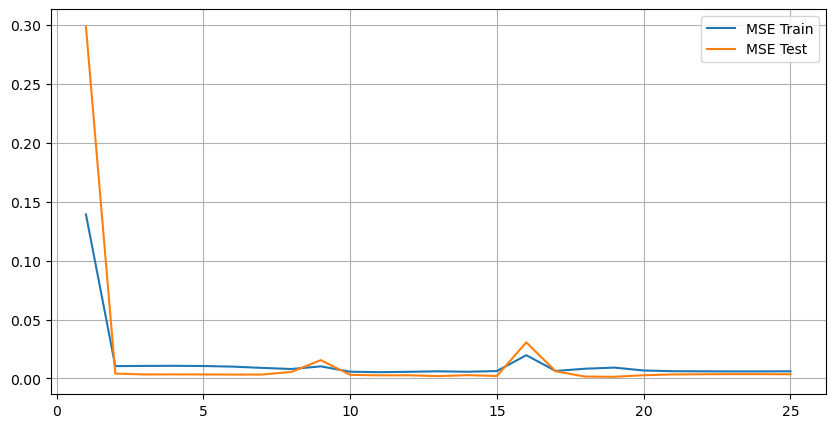

In [74]:
keys = list(RESULTS.keys())
time_elapsed, mse_train, mse_test = extract_metrics(RESULTS)

df = pd.DataFrame({
    'consrtaint_tol': keys,
    'time_elapsed': time_elapsed,
    'mse_train': mse_train,
    'mse_test': mse_test
})

df = df.dropna()

# plot
plt.figure(figsize=(10, 5))
plt.grid()
plt.plot(df['consrtaint_tol'], df['mse_train'], label='MSE Train')
plt.plot(df['consrtaint_tol'], df['mse_test'], label='MSE Test')
plt.legend()
plt.plot()

In [61]:
reload = False
if reload:
    formatted_time = time.strftime('%Y-%m-%d_%H-%M-%S')
    filename = f'results/{formatted_time}_training.pkl'
    with open(filename, 'wb') as file:
        pickle.dump(RESULTS, file)

---
---

In [157]:
RESULTS.keys()

dict_keys([('tanh', 'ho'), ('tanh', 'vdp'), ('tanh', 'do'), ('softplus', 'ho'), ('softplus', 'vdp'), ('softplus', 'do'), ('sigmoid', 'ho'), ('sigmoid', 'vdp'), ('sigmoid', 'do')])

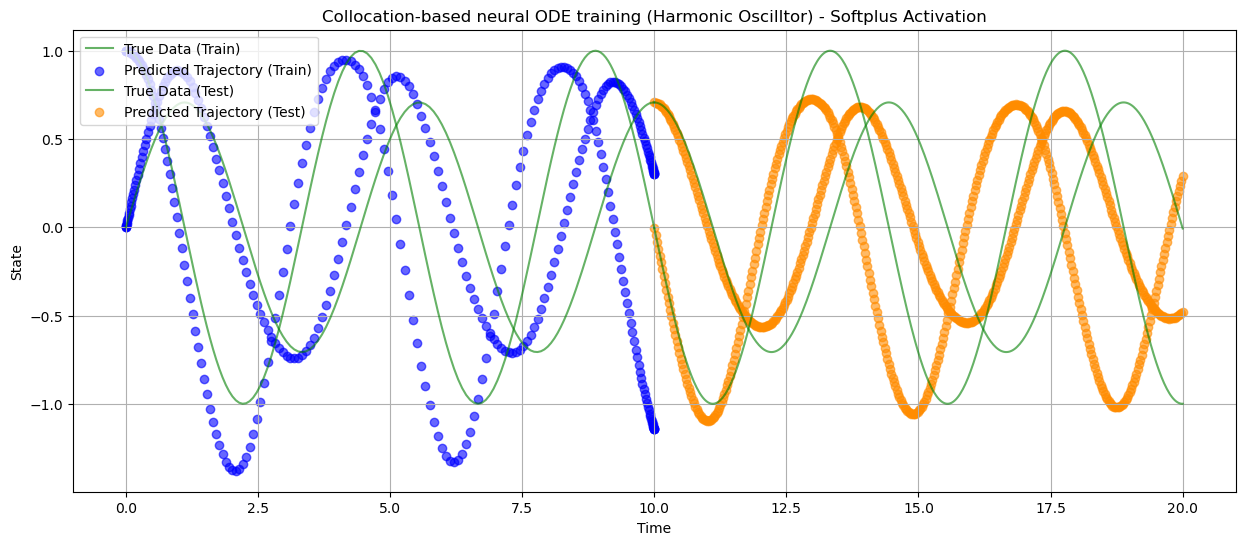

In [168]:
result = RESULTS[('softplus', 'ho')]
#TRAINER = load_trainer("ho")

y_pred = result['odeint_pred']
y_pred_test = result['odeint_pred_test']

plt.figure(figsize=(15, 6))

plt.plot(TRAINER.t, TRAINER.y[:,0], color = 'green', label='True Data (Train)', alpha = 0.6)
plt.plot(TRAINER.t, TRAINER.y[:,1], color = 'green', alpha = 0.6)
plt.scatter(TRAINER.t, y_pred[:,0], color = 'blue', label='Predicted Trajectory (Train)', alpha = 0.6)
plt.scatter(TRAINER.t, y_pred[:,1], color = 'blue', alpha = 0.6)

plt.plot(TRAINER.t_test, TRAINER.y_test[:,0], color='green', label='True Data (Test)', alpha = 0.6)
plt.plot(TRAINER.t_test, TRAINER.y_test[:,1], color='green', alpha = 0.6)
plt.scatter(TRAINER.t_test, y_pred_test[:,0], color='#FF8C00', label='Predicted Trajectory (Test)', alpha = 0.6)
plt.scatter(TRAINER.t_test, y_pred_test[:,1], color='#FF8C00', alpha = 0.6)

plt.title(f"Collocation-based neural ODE training (Harmonic Oscilltor) - Softplus Activation")
plt.xlabel("Time")
plt.ylabel("State")
plt.legend(loc ="upper left")
plt.grid(True)
plt.show()

In [ ]:
TRAINER

----